# **Download dataset from Kaggle**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"immanuelmayerd","key":"c0af11c2081e01520dcaa4c65a5076b8"}'}

Run this cell to install kaggle dependency, copy the file into ~/.kaggle/kaggle.json, and change file permissions to 600.

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download all the dataset using this command below.

In [4]:
!kaggle datasets download -d immanuelmayerd/14-indonesian-wayang-types

 92% 25.0M/27.3M [00:01<00:00, 23.2MB/s]
100% 27.3M/27.3M [00:01<00:00, 22.4MB/s]


Unzip the .zip file so we can see the DATASET folders. There are few version of the dataset since we experiment with different amount of Batik motives.

In [5]:
!unzip -qq /content/14-indonesian-wayang-types

# **Import All Dependencies**

In [6]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import os

In [7]:
cwd = os.getcwd()
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = os.path.join(cwd,"DATASET","TRAIN")
VALID_DATA_DIR = os.path.join(cwd,"DATASET","TEST")

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.


In [9]:
train_path = '/content/DATASET/TRAIN'
test_path = '/content/DATASET/TEST'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

types_dict = train_generator.class_indices
print(types_dict)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.
{'Abimanyu': 0, 'Antasena': 1, 'Arjuna': 2, 'Bagong': 3, 'Bima': 4, 'Cepot': 5, 'Gareng': 6, 'Gatot Kaca': 7, 'Hanoman': 8, 'Kresna': 9, 'Nakula': 10, 'Petruk': 11, 'Semar': 12, 'Yudhistira': 13}


In [10]:
#base model MobileNetV2
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=0.75,
    pooling='avg'
)

base_model.trainable = False

5914624/5903360 [==============================] - 0s 0us/step


In [11]:
#base model VGG16 (untuk saat ini jelek)

#from tensorflow.keras.applications.vgg16 import VGG16

#base_model = VGG16(
#    include_top=False,
#    weights='imagenet',
#    input_shape=(224, 224, 3),
#    pooling='avg'
#)

In [12]:
def scheduler(epoch, lr):
  if epoch <= 10:
    return lr
  elif 10 < epoch <= 20:
    return lr * tf.math.exp(-0.1)
  else:
    return lr * tf.math.exp(-0.2)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
EPOCHS = 100
LEARNING_RATE = 1e-4
TRAIN_STEP = 700//20
VAL_STEP = 200//20

In [14]:
clear_session()

model = Sequential([
    base_model,
    Dense(400, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.3),
    Dense(14, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.75_224 (Funct  (None, 1280)             1382064   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 400)               512400    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                5614      
                                                                 
Total params: 1,900,078
Trainable params: 518,014
Non-trainable params: 1,382,064
_________________________________________________________________


In [16]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Epoch 1/100
35/35 [==============================] - 27s 287ms/step - loss: 2.9490 - accuracy: 0.1357 - val_loss: 2.5435 - val_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - 10s 272ms/step - loss: 2.6228 - accuracy: 0.2214 - val_loss: 2.3200 - val_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - 11s 324ms/step - loss: 2.3947 - accuracy: 0.2743 - val_loss: 2.1505 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 4/100
35/35 [==============================] - 10s 287ms/step - loss: 2.2315 - accuracy: 0.3329 - val_loss: 1.9584 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 5/100
35/35 [==============================] - 10s 272ms/step - loss: 2.0614 - accuracy: 0.3829 - val_loss: 1.8908 - val_accuracy: 0.4950 - lr: 1.0000e-04
Epoch 6/100
35/35 [==============================] - 9s 268ms/step - loss: 1.9504 - accuracy: 0.4429 - val_loss: 1.7417 - val_accuracy: 0.5650 - lr: 1.0000e-04
Epoch 7/100
35/35 [================

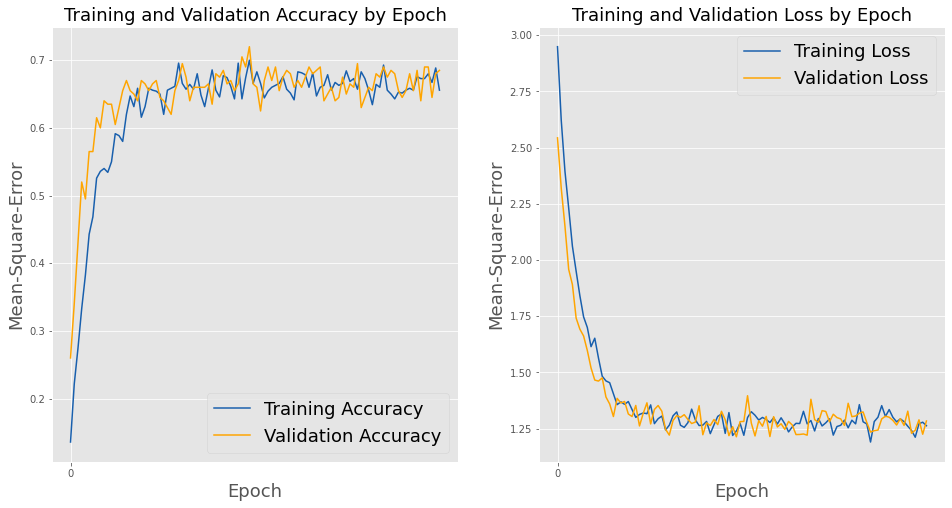

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16, 8))

# Cek hasil akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))

plt.legend(fontsize = 18);

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))

plt.legend(fontsize = 18)

# **Save The Model and Convert to .tflite**

In [18]:
model_save_path = "saved_model/15_motives"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models')
with open('tflite_models/wayang_types.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/15_motives/assets


INFO:tensorflow:Assets written to: saved_model/15_motives/assets
